# COSC2673 - Machine Learning - Assignment 2
### Authors: Louise Platts (S3908818) & Samuel Macintyre (S3888492)

# Classifying Images of Road Traffic Signs

#### Libraries Required

In [23]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

import tensorflow as tf
print(tf.__version__)
print(get_available_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.5.0
['/device:CPU:0', '/device:GPU:0']
Num GPUs Available:  1


In [24]:
# import statements
    
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import glob
from PIL import Image
import zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform



# Data Understanding & Data Preparation

In [25]:
def image_reader(path):
    image_list = []
    for filepath in glob.glob(path, recursive=True):
        shape = filepath.split("\\")[-3]
        type = filepath.split("\\")[-2]
        filename = filepath.split("\\")[-1]
        label = filename.split(".")[0]
        
        image_list.append({"filepath": filepath,'filename':filename,'label':label,'shape':shape,'type':type})

    dataset = pd.DataFrame(image_list)

    return dataset

def drop_unused_target(train, val, col):
    train1 = train.copy()
    val1 = val.copy()

    train1 = train1.drop(col,axis=1)
    val1 = val1.drop(col,axis=1)
    return train1, val1

In [26]:
raw_data = image_reader("./trafficsigns_dataset/*/*/*.png")
# raw_data.head()

# Split data into train and test
train_data, val_data = train_test_split(raw_data, test_size=0.2, random_state=42)

TOTAL_SHAPES = raw_data['shape'].nunique()
TOTAL_TYPES = raw_data['type'].nunique()

SHAPE_NAMES = raw_data['shape'].unique()
TYPE_NAMES = raw_data['type'].unique()

DIM = 28
RES_DIM = 28

test_image = Image.open(raw_data['filepath'][0])
NUM_BANDS = len(test_image.getbands())

print(f"Train data : {train_data.shape[0]}, Val Data: {val_data.shape[0]}")
print(f"Shape Classes:{SHAPE_NAMES}")
print(f"Type Classes: {TYPE_NAMES}")
print(f"Num Shape Classes: {TOTAL_SHAPES}, Num Type Classes: {TOTAL_TYPES}")


# Split training and validation into frames for respective classification type
shape_train_data, shape_val_data = drop_unused_target(train_data, val_data, "type")
type_train_data, type_val_data = drop_unused_target(train_data, val_data, "shape")


Train data : 2959, Val Data: 740
Shape Classes:['diamond' 'hex' 'round' 'square' 'triangle']
Type Classes: ['rightofway' 'stop' 'bicycle' 'limitedtraffic' 'noentry' 'noparking'
 'roundabout' 'speed' 'trafficdirective' 'traveldirection' 'continue'
 'crossing' 'laneend' 'parking' 'giveway' 'warning']
Num Shape Classes: 5, Num Type Classes: 16


In [ ]:
# Show some random images for context
r_inx = np.random.choice(100, 4)
rand_data = train_data.loc[r_inx,"image_path"]

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

KeyError: 'image_path'

In [28]:
def make_subplot(x,data,ax,order,title):
    fontsize = 12
    sns.countplot(x=x,data=data, order=order, ax=ax)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(x, fontsize=fontsize)
    ax.set_ylabel("Count", fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.tick_params(axis="x",rotation=90)


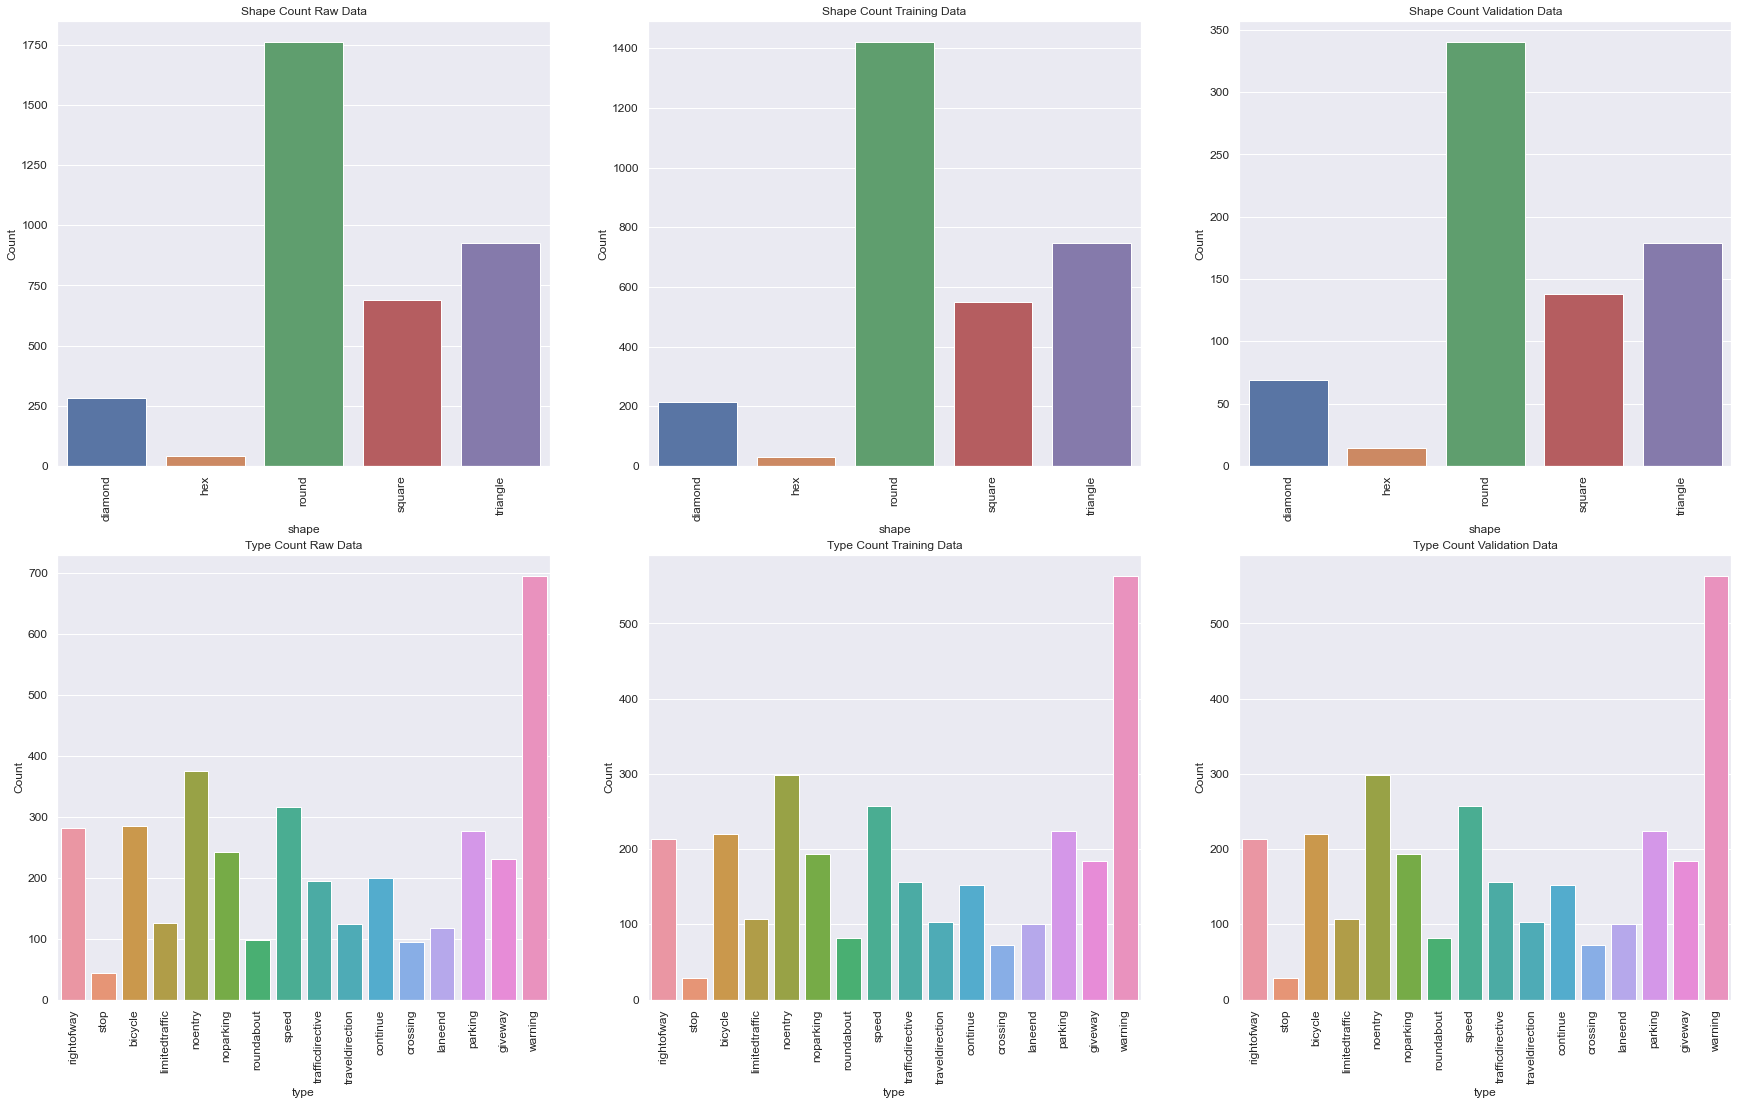

In [29]:
# Check Distribution of classes in training data splits compared to raw

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(2,3, figsize=(30,18))

make_subplot(x="shape",data=raw_data, order=SHAPE_NAMES, ax=ax[0,0], title="Shape Count Raw Data")
make_subplot(x="shape",data=shape_train_data, order=SHAPE_NAMES, ax=ax[0,1], title="Shape Count Training Data")
make_subplot(x="shape",data=shape_val_data, order=SHAPE_NAMES, ax=ax[0,2], title="Shape Count Validation Data")
make_subplot(x="type",data=raw_data, order=TYPE_NAMES, ax=ax[1,0], title="Type Count Raw Data")
make_subplot(x="type",data=type_train_data, order=TYPE_NAMES, ax=ax[1,1], title="Type Count Training Data")
make_subplot(x="type",data=type_train_data, order=TYPE_NAMES, ax=ax[1,2], title="Type Count Validation Data")


# Modelling & Evaluation

In [30]:
class CNNModel:

    def __init__(self, epochs=100, activation="relu"):
        self.epochs = epochs
        self.activation = activation

    def create_data_generator(self, df,datagen,batch_size,target,target_size=(28,28)):
        print(target_size)
        generator = datagen.flow_from_dataframe(
            dataframe=df,
            directory = './',
            x_col='filepath',
            y_col=target,
            target_size=target_size,
            batch_size=batch_size,
            color_mode="grayscale",
            class_mode='categorical',
            rotation_range=45,
            width_shift_range=0.2,
            height_shift_range=0.2,
            brightness_range=[0.75,1.25],
            random_zoom=[0.75,1.25],
            horizontal_flip=True,
            vertical_flip=True
        )

        return generator

    def build_vgg_model(self, num_classes):

        self.model = tf.keras.Sequential([
            #VGG block 1
            tf.keras.layers.Conv2D(DIM, (3, 3), activation=self.activation, padding='same', input_shape=(DIM, DIM, NUM_BANDS)),
            tf.keras.layers.Conv2D(DIM, (3, 3), activation=self.activation, padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            
            #VGG block 2
            tf.keras.layers.Conv2D(DIM*2, (3, 3), activation=self.activation, padding='same'),
            tf.keras.layers.Conv2D(DIM*2, (3, 3), activation=self.activation, padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            
            #VGG block 3
            tf.keras.layers.Conv2D(DIM*4, (3, 3), activation=self.activation, padding='same'),
            tf.keras.layers.Conv2D(DIM*4, (3, 3), activation=self.activation, padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(DIM*4, activation=self.activation),
            tf.keras.layers.Dense(num_classes)
        ])

    def build_resnet_model(self,num_classes):
        self.model = ResNetModified(num_classes=num_classes, activation=self.activation, input_shape=(RES_DIM,RES_DIM,NUM_BANDS))

    def compile_resnet_model(self):
        self.model.compile(optimizer="adam", 
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
            metrics=["categorical_accuracy"])
    
    def compile_vgg_model(self):
        self.model.compile(optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics=['categorical_accuracy'])

    def fit_model(self):
       return self.model.fit_generator(self.train_generator, validation_data=self.val_generator,\
           epochs=self.epochs,verbose=1)
    

### Baseline Model
VGG Baseline Model


In [31]:
shape_train_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')
shape_val_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')

type_train_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')
type_val_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')

# RESNET PAPER USED Batch Size DIM*4. Batchsize to be updated later (Impact on Run Time)
vgg_batch_size = 32


vgg_shape_model = CNNModel()
vgg_type_model = CNNModel()


# Baseline VGG Shape Model Data Generators
vgg_shape_model.train_generator = vgg_shape_model.create_data_generator(\
    shape_train_data,shape_train_datagen,vgg_batch_size,"shape")

vgg_shape_model.val_generator = vgg_shape_model.create_data_generator(\
    shape_val_data,shape_val_datagen,vgg_batch_size,"shape")

# Baseline VGG Type Model Data Generators
vgg_type_model.train_generator = vgg_type_model.create_data_generator(\
    type_train_data,type_train_datagen,vgg_batch_size,"type")

vgg_type_model.val_generator = vgg_type_model.create_data_generator(\
    type_val_data,type_val_datagen,vgg_batch_size,"type")



(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.
(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.


In [32]:
# Build Model
vgg_shape_model.build_vgg_model(TOTAL_SHAPES)
vgg_type_model.build_vgg_model(TOTAL_TYPES)

In [33]:
vgg_shape_model.compile_vgg_model()
vgg_type_model.compile_vgg_model()

vgg_shape_fit = vgg_shape_model.fit_model()
vgg_type_fit = vgg_type_model.fit_model()

c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
93/93 [==============================] - 9s 18ms/step - loss: 0.9291 - categorical_accuracy: 0.6512 - val_loss: 0.3479 - val_categorical_accuracy: 0.9081
Epoch 2/100
93/93 [==============================] - 1s 15ms/step - loss: 0.1583 - categorical_accuracy: 0.9571 - val_loss: 0.0967 - val_categorical_accuracy: 0.9703
Epoch 3/100
93/93 [==============================] - 2s 16ms/step - loss: 0.0548 - categorical_accuracy: 0.9845 - val_loss: 0.0289 - val_categorical_accuracy: 0.9905
Epoch 4/100
93/93 [==============================] - 1s 16ms/step - loss: 0.0192 - categorical_accuracy: 0.9926 - val_loss: 0.0760 - val_categorical_accuracy: 0.9784
Epoch 5/100
93/93 [==============================] - 1s 16ms/step - loss: 0.0179 - categorical_accuracy: 0.9949 - val_loss: 0.0379 - val_categorical_accuracy: 0.9878
Epoch 6/100
93/93 [==============================] - 1s 15ms/step - loss: 0.0186 - categorical_accuracy: 0.9929 - val_loss: 0.0597 - val_categorical_accuracy: 0.9838
Epoc

In [34]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy', title=None):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')
    plt.title(title)

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')
    plt.title(title)
    plt.show()

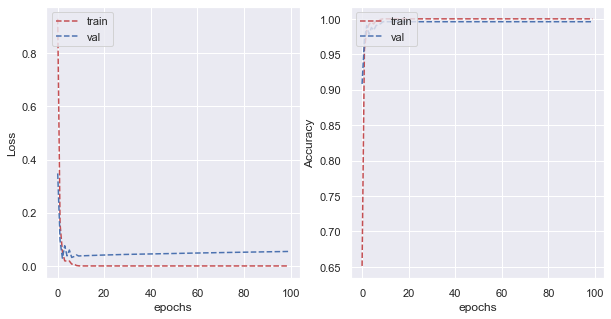

In [35]:
plot_learning_curve(vgg_shape_fit.history['loss'], vgg_shape_fit.history['val_loss'], 
                    vgg_shape_fit.history['categorical_accuracy'], vgg_shape_fit.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

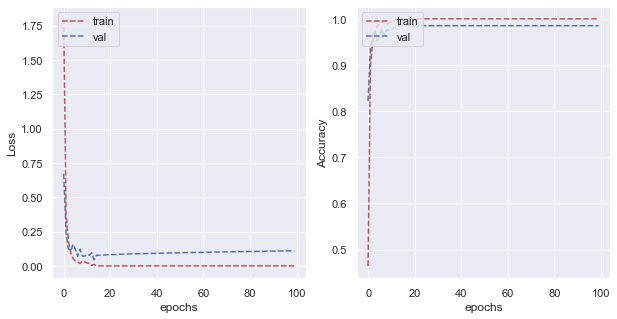

In [36]:
plot_learning_curve(vgg_type_fit.history['loss'], vgg_type_fit.history['val_loss'], 
                    vgg_type_fit.history['categorical_accuracy'], vgg_type_fit.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Resnet Model
https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb


In [37]:
# identity block -> standard block used in ResNets 
def identity_block(X, activation, f, filters, stage, block):
    '''
    identity blocks are required to transform into a residual network 
    inputs:
    X -> input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -> integer determining the shape of the middle CONV's window
    filters -> list of integers, defines number of filters in the CONV layer 
    stage -> integer, names the layers depending on position in NN
    block -> string, used to name the layers, depending on their position in the network

    outputs:
    X -> the identity block, tensor of shape (n_H, n_W, n_C)
    '''
    # defines the name of branch according to current position
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"

    # retrieve the filters to apply
    F1, F2, F3 = filters

    # save current input tensor
    X_save = X 

    # first component 
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding="valid", name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    # normalises the channels axis
    X = BatchNormalization(axis=-1, name=bn_name_base+"2a")(X)
    X = Activation(activation)(X)

    # second component
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding="same", name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+"2b")(X)
    X = Activation(activation)(X)

    # third component
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid", name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+"2c")(X)

    # add shorcut connection to main path 
    X = Add()([X, X_save])
    X = Activation(activation)(X)

    return X
    

In [38]:
# convolutional block -> standard block used in ResNets to ensure input and ouptut dimension
def convolutional_block(X, activation, f, filters, stage, block, s=2):
    '''
    identity blocks are required to transform into a residual network 
    inputs:
    X -> input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -> integer determining the shape of the middle CONV's window
    filters -> list of integers, defines number of filters in the CONV layer 
    stage -> integer, names the layers depending on position in NN
    block -> string, used to name the layers, depending on their position in the network
    s -> integer, specifies the stride to be used, i.e. to reduce the dimension by a factor of 2, use a stride of 2

    outputs:
    X -> the identity block, tensor of shape (n_H, n_W, n_C)
    '''
    # defines the name of branch according to current position
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"

    # retrieve the filters to apply
    F1, F2, F3 = filters

    # to build shortcut path
    X_shortcut = X 

    # first component 
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding="valid", name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    # normalises the channels axis
    X = BatchNormalization(axis=-1, name=bn_name_base+"2a")(X)
    X = Activation(activation)(X)

    # second component
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding="same", name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+"2b")(X)
    X = Activation(activation)(X)

    # third component
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid", name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+"2c")(X)

    # build the shortcut path 
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding="valid", name=conv_name_base+"1", kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=-1, name=bn_name_base+"1")(X_shortcut)


    # add shortcut connection to main path 
    X = Add()([X, X_shortcut])
    X = Activation(activation)(X)

    return X

In [39]:
# modified version of 50 layer ResNet Model
def ResNetModified(num_classes, activation, input_shape=(DIM,DIM,NUM_BANDS)):
    '''
    ResNetModified Architecture follows:
    (stage 1) = CONV2D -> BN -> RELU -> MAXPOOL -> 
    stage 2 = CONVBLOCK -> IDBLOCK x 2 -> 
    stage 3 = CONVBLOCK -> IDBLOCK X 3 -> 
    stage 4 = CONVBLOCK -> IDBLOCK X 5 -> 
    # stage 5 = CONVBLOCK -> IDBLOCK x 2 -> 
    (stage 6) = AVGPOOL -> TOP LAYER

    inputs:
    input_shape -> shape of images in dataset 
    classes -> number of classes to predict

    outputs:
    model -> a Keras Model() instance for training
    '''
    # set the input shape
    X_input = Input(input_shape)

    # initialise the zero padding
    X = ZeroPadding2D((3,3))(X_input)

    # implement the architecture
    X = Conv2D(DIM, (7,7), strides=(2,2), name="conv1", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1, name="bn_conv1")(X)
    X = Activation(activation)(X)
    X = MaxPooling2D((3,3), strides=(2,2))(X)

    X = convolutional_block(X, activation, f=3, filters=[DIM,DIM,DIM*4], stage=2, block="a", s=1)
    X = identity_block(X, activation, 3, [DIM,DIM,DIM*4], stage=2, block="b")
    X = identity_block(X, activation, 3, [DIM,DIM,DIM*4], stage=2, block="c")

    X = convolutional_block(X, activation, f=3, filters=[DIM*2,DIM*2,DIM*8], stage=3, block="a", s=2)
    X = identity_block(X, activation, 3, [DIM*2,DIM*2,DIM*8], stage=3, block="b")
    X = identity_block(X, activation, 3, [DIM*2,DIM*2,DIM*8], stage=3, block="c")
    X = identity_block(X, activation, 3, [DIM*2,DIM*2,DIM*8], stage=3, block="d")

    X = convolutional_block(X, activation, f=3, filters=[DIM*4,DIM*4,DIM*16], stage=4, block="a", s=2)
    X = identity_block(X, activation, 3, [DIM*4,DIM*4,DIM*16], stage=4, block="b")
    X = identity_block(X, activation, 3, [DIM*4,DIM*4,DIM*16], stage=4, block="c")
    X = identity_block(X, activation, 3, [DIM*4,DIM*4,DIM*16], stage=4, block="d")
    X = identity_block(X, activation, 3, [DIM*4,DIM*4,DIM*16], stage=4, block="e")
    X = identity_block(X, activation, 3, [DIM*4,DIM*4,DIM*16], stage=4, block="f")

    # X = convolutional_block(X, f=3, filters=[DIM*8,DIM*8,DIM*32], stage=5, block="a", s=2)
    # X = identity_block(X, 3, [DIM*8,DIM*8,DIM*32], stage=5, block="b")
    # X = identity_block(X, 3, [DIM*8,DIM*8,DIM*32], stage=5, block="c")

    X = AveragePooling2D((2,2), name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(num_classes, activation="softmax", name="fc"+str(num_classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # create the resnet model
    model = Model(inputs=X_input, outputs=X, name="ResNetModified")

    return model

In [41]:
resnet_batch_size = 32
resnet_target_size=(RES_DIM,RES_DIM)

resnet_shape_model = CNNModel()
resnet_type_model = CNNModel()


# Baseline ResNetModified Shape Model Data Generators
resnet_shape_model.train_generator = resnet_shape_model.create_data_generator(\
    shape_train_data,shape_train_datagen,resnet_batch_size,"shape",target_size=resnet_target_size)

resnet_shape_model.val_generator = resnet_shape_model.create_data_generator(\
    shape_val_data,shape_val_datagen,resnet_batch_size,"shape",target_size=resnet_target_size)

# Baseline ResNetModified Type Model Data Generators
resnet_type_model.train_generator = resnet_type_model.create_data_generator(\
    type_train_data,type_train_datagen,resnet_batch_size,"type",target_size=resnet_target_size)

resnet_type_model.val_generator = resnet_type_model.create_data_generator(\
    type_val_data,type_val_datagen,resnet_batch_size,"type",target_size=resnet_target_size)


# Build Model
resnet_shape_model.build_resnet_model(TOTAL_SHAPES)
resnet_type_model.build_resnet_model(TOTAL_TYPES)

# Compile Model
resnet_shape_model.compile_resnet_model()
resnet_type_model.compile_resnet_model()

# Fit Model
resnet_shape_fit = resnet_shape_model.fit_model()
resnet_type_fit = resnet_type_model.fit_model()

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.
(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
93/93 [==============================] - 10s 57ms/step - loss: 1.1756 - categorical_accuracy: 0.6816 - val_loss: 1.3259 - val_categorical_accuracy: 0.4595
Epoch 2/100
93/93 [==============================] - 4s 45ms/step - loss: 0.3226 - categorical_accuracy: 0.9000 - val_loss: 1.2286 - val_categorical_accuracy: 0.4608
Epoch 3/100
93/93 [==============================] - 4s 44ms/step - loss: 0.1541 - categorical_accuracy: 0.9537 - val_loss: 1.5611 - val_categorical_accuracy: 0.5243
Epoch 4/100
93/93 [==============================] - 4s 47ms/step - loss: 0.0914 - categorical_accuracy: 0.9743 - val_loss: 0.5955 - val_categorical_accuracy: 0.8176
Epoch 5/100
93/93 [==============================] - 4s 43ms/step - loss: 0.0960 - categorical_accuracy: 0.9696 - val_loss: 1.0928 - val_categorical_accuracy: 0.7541
Epoch 6/100
93/93 [==============================] - 4s 43ms/step - loss: 0.0974 - categorical_accuracy: 0.9669 - val_loss: 0.1662 - val_categorical_accuracy: 0.9419
Epo

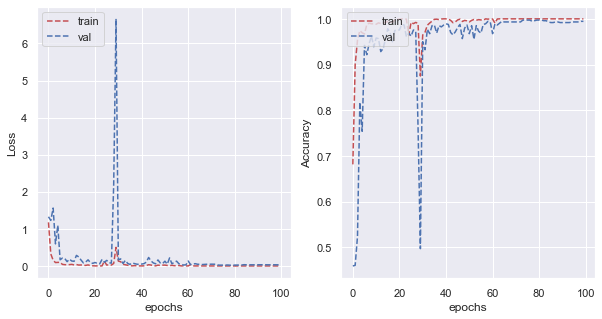

In [42]:
plot_learning_curve(resnet_shape_fit.history['loss'], resnet_shape_fit.history['val_loss'], 
                    resnet_shape_fit.history['categorical_accuracy'], resnet_shape_fit.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

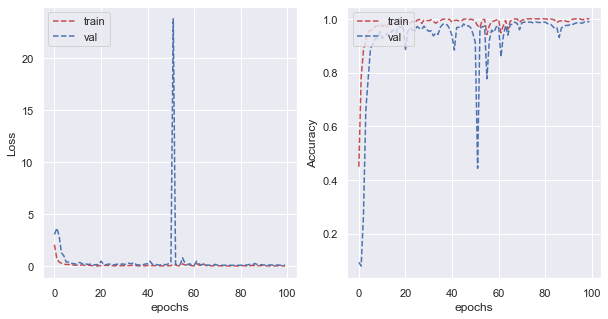

In [43]:
plot_learning_curve(resnet_type_fit.history['loss'], resnet_type_fit.history['val_loss'], 
                    resnet_type_fit.history['categorical_accuracy'], resnet_type_fit.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
# tf.keras.utils.plot_model(resnet_shape_model.model, show_shapes=True)

# Hyper-Parameter Tuning - VGG Type as better than initial ResNet Type model

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.
Epoch 1/10


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


296/296 [==============================] - 4s 10ms/step - loss: 1.5404 - categorical_accuracy: 0.5414 - val_loss: 0.2670 - val_categorical_accuracy: 0.9216
Epoch 2/10
296/296 [==============================] - 3s 8ms/step - loss: 0.2218 - categorical_accuracy: 0.9371 - val_loss: 0.2243 - val_categorical_accuracy: 0.9311
Epoch 3/10
296/296 [==============================] - 3s 10ms/step - loss: 0.1128 - categorical_accuracy: 0.9686 - val_loss: 0.1135 - val_categorical_accuracy: 0.9635
Epoch 4/10
296/296 [==============================] - 3s 11ms/step - loss: 0.0716 - categorical_accuracy: 0.9763 - val_loss: 0.1317 - val_categorical_accuracy: 0.9595
Epoch 5/10
296/296 [==============================] - 3s 11ms/step - loss: 0.0361 - categorical_accuracy: 0.9882 - val_loss: 0.0616 - val_categorical_accuracy: 0.9851
Epoch 6/10
296/296 [==============================] - 3s 9ms/step - loss: 0.0493 - categorical_accuracy: 0.9851 - val_loss: 0.1136 - val_categorical_accuracy: 0.9676
Epoch 7/10


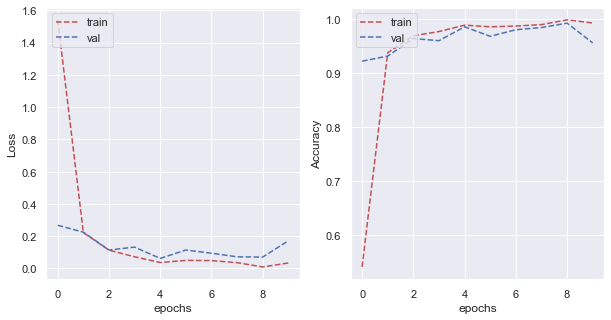

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.
Epoch 1/10


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


296/296 [==============================] - 4s 9ms/step - loss: 2.6322 - categorical_accuracy: 0.1849 - val_loss: 2.6174 - val_categorical_accuracy: 0.1784
Epoch 2/10
296/296 [==============================] - 3s 9ms/step - loss: 2.5987 - categorical_accuracy: 0.1903 - val_loss: 2.6178 - val_categorical_accuracy: 0.1784
Epoch 3/10
296/296 [==============================] - 3s 9ms/step - loss: 2.5988 - categorical_accuracy: 0.1903 - val_loss: 2.6074 - val_categorical_accuracy: 0.1784
Epoch 4/10
296/296 [==============================] - 3s 10ms/step - loss: 2.5974 - categorical_accuracy: 0.1903 - val_loss: 2.6026 - val_categorical_accuracy: 0.1784
Epoch 5/10
296/296 [==============================] - 3s 9ms/step - loss: 2.5979 - categorical_accuracy: 0.1903 - val_loss: 2.6032 - val_categorical_accuracy: 0.1784
Epoch 6/10
296/296 [==============================] - 3s 9ms/step - loss: 2.5977 - categorical_accuracy: 0.1903 - val_loss: 2.6009 - val_categorical_accuracy: 0.1784
Epoch 7/10
296

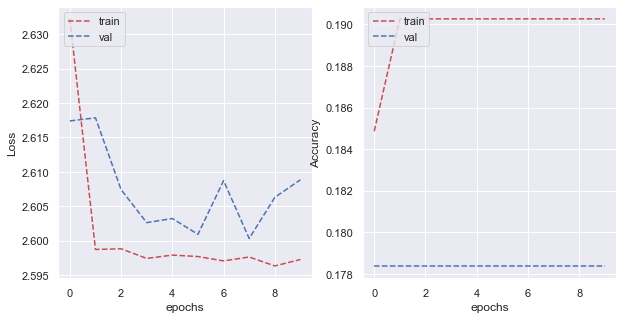

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.
Epoch 1/10


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


296/296 [==============================] - 4s 12ms/step - loss: 0.5642 - categorical_accuracy: 0.8378 - val_loss: 0.0826 - val_categorical_accuracy: 0.9824
Epoch 2/10
296/296 [==============================] - 3s 12ms/step - loss: 0.0717 - categorical_accuracy: 0.9831 - val_loss: 0.0518 - val_categorical_accuracy: 0.9919
Epoch 3/10
296/296 [==============================] - 3s 11ms/step - loss: 0.0237 - categorical_accuracy: 0.9946 - val_loss: 0.0298 - val_categorical_accuracy: 0.9919
Epoch 4/10
296/296 [==============================] - 3s 11ms/step - loss: 0.0147 - categorical_accuracy: 0.9970 - val_loss: 0.0173 - val_categorical_accuracy: 0.9986
Epoch 5/10
296/296 [==============================] - 3s 11ms/step - loss: 0.0016 - categorical_accuracy: 1.0000 - val_loss: 0.0165 - val_categorical_accuracy: 0.9959
Epoch 6/10
296/296 [==============================] - 3s 11ms/step - loss: 8.3157e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0142 - val_categorical_accuracy: 0.9973
Epoch

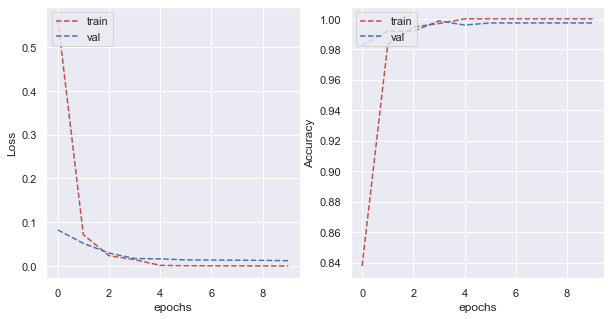

In [45]:
from sklearn.model_selection import ParameterGrid
# want to tune batch size, epochs
parameters = {"batch_size": [10, 20, 40, 60, 80, 100], "epochs" : [10, 50, 100], "activation":["relu", "sigmoid", "tanh"]}

# save results of tuning for later accessing 
vgg_type_saved_results = {}
attempt = 0

# use parameter grid to generate permutations 
model_parameters = list(ParameterGrid(parameters))

for each in model_parameters:
    # need to tune batch size, so we initalise and build model + generator according to batch size
    type_train_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')
    type_val_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')

    vgg_type_model = CNNModel(activation=each["activation"])

    # Baseline VGG Type Model Data Generators
    vgg_type_model.train_generator = vgg_type_model.create_data_generator(\
        type_train_data,type_train_datagen, each["batch_size"],"type")

    vgg_type_model.val_generator = vgg_type_model.create_data_generator(\
        type_val_data,type_val_datagen,each["batch_size"],"type")

    # build and compile the model for tuning 
    vgg_type_model.build_vgg_model(TOTAL_TYPES)
    vgg_type_model.compile_vgg_model()

    # fit the model 
    vgg_type_fit = vgg_type_model.model.fit_generator(vgg_type_model.train_generator, validation_data=vgg_type_model.val_generator,\
           epochs=each["epochs"],verbose=1)
    
    vgg_type_saved_results[attempt] = {"batch":each["batch_size"], "epoch":each["epochs"], "activation":each["activation"], "best_val_accuracy":max(vgg_type_fit.history["val_categorical_accuracy"]), \
        "loss":vgg_type_fit.history['loss'], "val_loss":vgg_type_fit.history['val_loss'], \
        "accuracy":vgg_type_fit.history['categorical_accuracy'], "val_accuracy":vgg_type_fit.history['val_categorical_accuracy']}
    attempt += 1
    print("For batch size {}, epochs of {}, activation function {}, performance:".format(each["batch_size"], each["epochs"], each["activation"]))
    plot_learning_curve(vgg_type_fit.history['loss'], vgg_type_fit.history['val_loss'], 
                    vgg_type_fit.history['categorical_accuracy'], vgg_type_fit.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
    
    

In [ ]:
vgg_type_saved_results

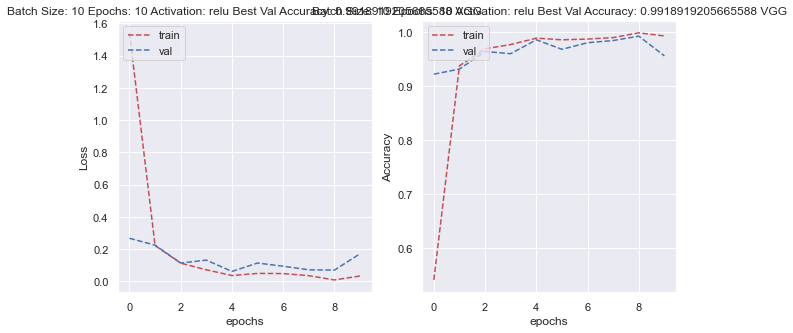

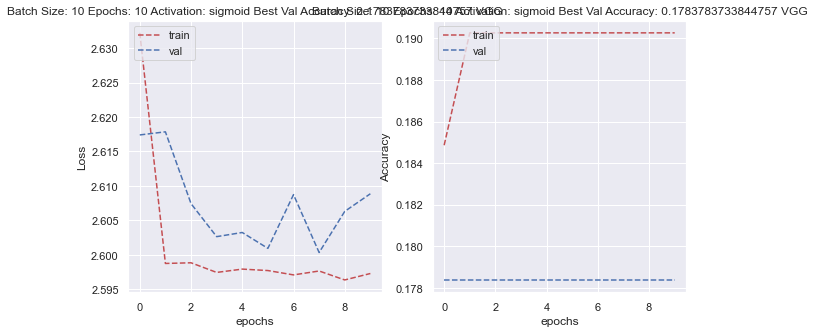

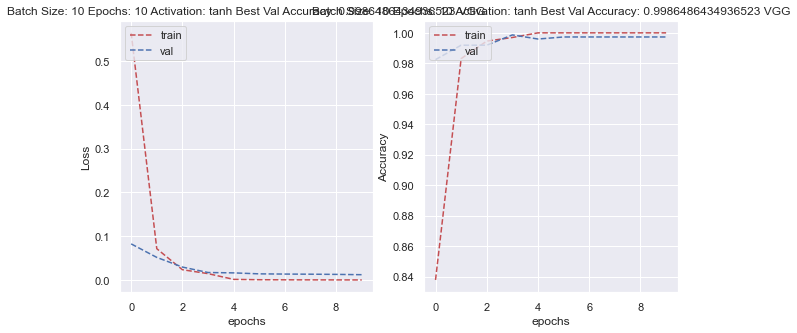

In [46]:
for i in range(0, len(vgg_type_saved_results)):
    plot_title = "Batch Size: {} Epochs: {} Activation: {} Best Val Accuracy: {} VGG".format(vgg_type_saved_results[i]["batch"], vgg_type_saved_results[i]["epoch"], vgg_type_saved_results[i]["activation"], vgg_type_saved_results[i]["best_val_accuracy"])
    plot_learning_curve(vgg_type_saved_results[i]["loss"], vgg_type_saved_results[i]["val_loss"], 
                    vgg_type_saved_results[i]["accuracy"], vgg_type_saved_results[i]["val_accuracy"], 
                    metric_name='Accuracy', title=plot_title)

# Hyper Parameter Tuning - ResNet Shape as better than initial VGG Shape model

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
296/296 [==============================] - 22s 52ms/step - loss: 1.1866 - categorical_accuracy: 0.6499 - val_loss: 1.3609 - val_categorical_accuracy: 0.5230
Epoch 2/10
296/296 [==============================] - 13s 45ms/step - loss: 0.4582 - categorical_accuracy: 0.8706 - val_loss: 0.5909 - val_categorical_accuracy: 0.7730
Epoch 3/10
296/296 [==============================] - 14s 47ms/step - loss: 0.3189 - categorical_accuracy: 0.9040 - val_loss: 0.2296 - val_categorical_accuracy: 0.9162
Epoch 4/10
296/296 [==============================] - 14s 48ms/step - loss: 0.1454 - categorical_accuracy: 0.9557 - val_loss: 0.1782 - val_categorical_accuracy: 0.9338
Epoch 5/10
296/296 [==============================] - 14s 48ms/step - loss: 0.1044 - categorical_accuracy: 0.9696 - val_loss: 0.1094 - val_categorical_accuracy: 0.9649
Epoch 6/10
296/296 [==============================] - 14s 48ms/step - loss: 0.0528 - categorical_accuracy: 0.9821 - val_loss: 0.1188 - val_categorical_accuracy:

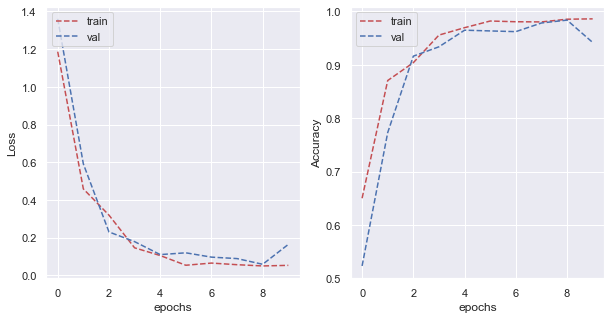

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
296/296 [==============================] - 21s 50ms/step - loss: 0.8118 - categorical_accuracy: 0.6658 - val_loss: 2.0539 - val_categorical_accuracy: 0.1865
Epoch 2/10
296/296 [==============================] - 14s 46ms/step - loss: 0.6500 - categorical_accuracy: 0.7046 - val_loss: 0.7774 - val_categorical_accuracy: 0.6568
Epoch 3/10
296/296 [==============================] - 14s 47ms/step - loss: 0.6118 - categorical_accuracy: 0.7124 - val_loss: 4.9977 - val_categorical_accuracy: 0.2419
Epoch 4/10
296/296 [==============================] - 14s 48ms/step - loss: 0.4828 - categorical_accuracy: 0.7810 - val_loss: 0.6273 - val_categorical_accuracy: 0.7730
Epoch 5/10
296/296 [==============================] - 14s 47ms/step - loss: 0.4095 - categorical_accuracy: 0.8557 - val_loss: 1.0052 - val_categorical_accuracy: 0.5824
Epoch 6/10
296/296 [==============================] - 14s 47ms/step - loss: 0.3191 - categorical_accuracy: 0.8952 - val_loss: 4.7432 - val_categorical_accuracy:

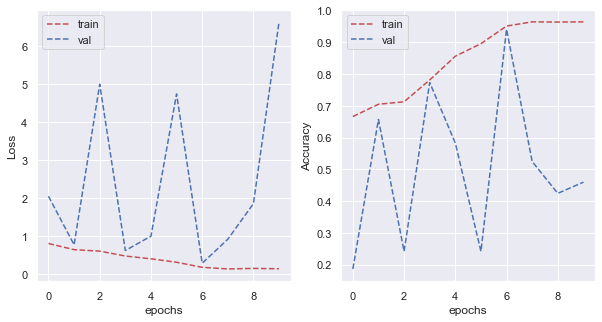

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
296/296 [==============================] - 21s 51ms/step - loss: 0.7665 - categorical_accuracy: 0.7388 - val_loss: 0.6728 - val_categorical_accuracy: 0.7581
Epoch 2/10
296/296 [==============================] - 14s 48ms/step - loss: 0.3433 - categorical_accuracy: 0.8959 - val_loss: 0.5013 - val_categorical_accuracy: 0.8203
Epoch 3/10
296/296 [==============================] - 15s 50ms/step - loss: 0.2653 - categorical_accuracy: 0.9243 - val_loss: 0.3785 - val_categorical_accuracy: 0.8946
Epoch 4/10
296/296 [==============================] - 14s 48ms/step - loss: 0.2303 - categorical_accuracy: 0.9334 - val_loss: 0.2779 - val_categorical_accuracy: 0.9216
Epoch 5/10
296/296 [==============================] - 14s 47ms/step - loss: 0.1559 - categorical_accuracy: 0.9584 - val_loss: 0.2196 - val_categorical_accuracy: 0.9257
Epoch 6/10
296/296 [==============================] - 14s 48ms/step - loss: 0.1569 - categorical_accuracy: 0.9520 - val_loss: 0.3227 - val_categorical_accuracy:

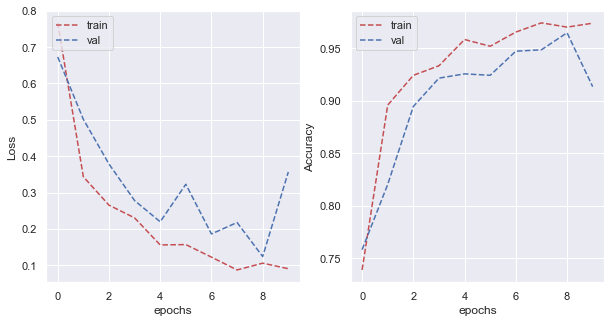

In [48]:
# want to tune batch size, epochs
parameters = {"batch_size": [10, 20, 40, 60, 80, 100], "epochs" : [10, 50, 100], "activation":["relu", "sigmoid", "tanh"]}

# save results of tuning for later accessing 
resnet_shape_saved_results = {}
attempt = 0

# use parameter grid to generate permutations 
model_parameters = list(ParameterGrid(parameters))

for each in model_parameters:
    # need to tune batch size, so we initalise and build model + generator according to batch size
    shape_train_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')
    shape_val_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')

    resnet_shape_model = CNNModel(activation=each["activation"])

    # Baseline ResNet Shape Model Data Generators
    resnet_shape_model.train_generator = resnet_shape_model.create_data_generator(\
        shape_train_data,shape_train_datagen, each["batch_size"],"shape")

    resnet_shape_model.val_generator = resnet_shape_model.create_data_generator(\
        shape_val_data,shape_val_datagen,each["batch_size"],"shape")

    # build and compile the model for tuning 
    resnet_shape_model.build_resnet_model(TOTAL_SHAPES)
    resnet_shape_model.compile_resnet_model()

    # fit the model 
    resnet_shape_fit = resnet_shape_model.model.fit_generator(resnet_shape_model.train_generator, validation_data=resnet_shape_model.val_generator,\
           epochs=each["epochs"],verbose=1)
    
    resnet_shape_saved_results[attempt] = {"batch":each["batch_size"], "epoch":each["epochs"], "activation":each["activation"], "best_val_accuracy":max(resnet_shape_fit.history["val_categorical_accuracy"]), \
        "loss":resnet_shape_fit.history['loss'], "val_loss":resnet_shape_fit.history['val_loss'], \
        "accuracy":resnet_shape_fit.history['categorical_accuracy'], "val_accuracy":resnet_shape_fit.history['val_categorical_accuracy']}
    attempt += 1
    print("For batch size {}, epochs of {}, activation function {}, performance:".format(each["batch_size"], each["epochs"], each["activation"]))
    plot_learning_curve(resnet_shape_fit.history['loss'], resnet_shape_fit.history['val_loss'], 
                    resnet_shape_fit.history['categorical_accuracy'], resnet_shape_fit.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
resnet_shape_saved_results

In [ ]:
for i in range(0, len(resnet_shape_saved_results)):
    plot_title = "Batch Size: {} Epochs: {} Activation: {} Best Val Accuracy: {} ResNet".format(resnet_shape_saved_results[i]["batch"], resnet_shape_saved_results[i]["epoch"], resnet_shape_saved_results[i]["activation"], resnet_shape_saved_results[i]["best_val_accuracy"])
    plot_learning_curve(resnet_shape_saved_results[i]["loss"], resnet_shape_saved_results[i]["val_loss"], 
                    resnet_shape_saved_results[i]["accuracy"], resnet_shape_saved_results[i]["val_accuracy"], 
                    metric_name='Accuracy', title=plot_title)

## Ultimate Judgement - Sign-Shape

## Ultimate Judgement - Sign-Type

# Deployment on Independent Data